# Bringing Knowledge from Prev Sections

    - Feature Engineering Results: Alcohol
    - Feature Selection Results: Medu, health, age, absences, Alcohol, freetime, failures

# Modelling

Index(['G3', 'school', 'sex', 'address', 'Pstatus', 'Medu', 'Fedu', 'Mjob',
       'reason', 'traveltime', 'higher', 'internet', 'romantic', 'famrel',
       'health', 'absences', 'Alcohol', 'Support', 'Social', 'Study',
       'Repeater', 'Guardian', 'Fjob'],
      dtype='object')
395 395


--OverSampling On-- 

Resample dataset shape Counter({2: 295, 1: 295, 0: 295}) 

--LOW VARIANCE FILTER ON-- 

Selected ['school', 'sex', 'address', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'reason', 'traveltime', 'internet', 'romantic', 'famrel', 'health', 'absences', 'Alcohol', 'Support', 'Social', 'Study', 'Repeater', 'Guardian', 'Fjob']
Features (total, selected): 22 21


--ML Model Output-- 

Decision Tree Acc: 0.88 (+/- 0.04)
F1 score: 0.8723163841807909


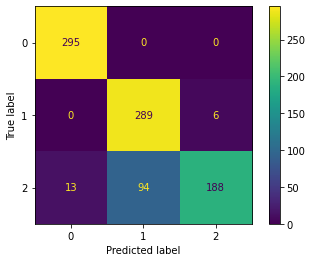

CV Runtime: 0.22688531875610352 

Random Forest Acc: 0.96 (+/- 0.04)
F1 score: 0.9514124293785311


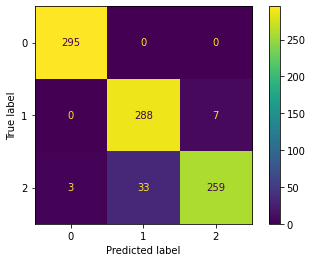

CV Runtime: 6.407488584518433 

Gradient Boosting Acc: 0.86 (+/- 0.12)
F1 score: 0.864406779661017


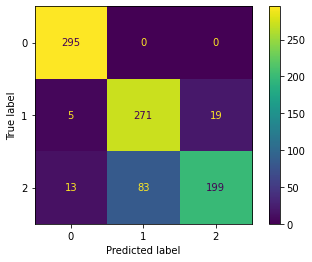

CV Runtime: 5.4070048332214355 

MLP Acc: 0.87 (+/- 0.09)
F1 score: 0.8734463276836159


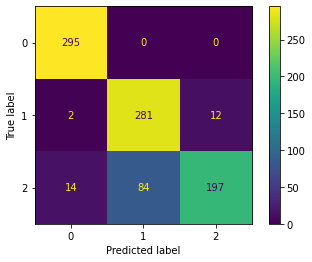

CV Runtime: 2.2324910163879395 

SVM Acc: 0.84 (+/- 0.02)
F1 score: 0.8440677966101696


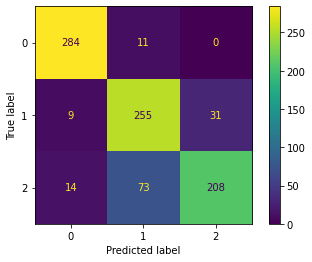

CV Runtime: 0.6256694793701172


In [65]:
#Scikit Template
'''created by Casey Bennett 2018, www.CaseyBennett.com
   Copyright 2018

   This program is free software: you can redistribute it and/or modify
   it under the terms of the GNU General Public License (Lesser GPL) as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
'''

import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import joblib
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics, svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, train_test_split, cross_val_predict
from sklearn.preprocessing import KBinsDiscretizer, scale, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
import matplotlib.pyplot as plt


#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


#############################################################################
#
# Global parameters
#
#####################

target_idx=0                                        #Index of Target variable
cross_val=1                                         #Control Switch for CV
norm_target=0                                       #Normalize target switch
norm_features=1                                     #Normalize target switch
pre_binned = 1                                      # 1 if classes are already binned, 0 otherwise
binning=1                                           #Control Switch for Bin Target
bin_cnt=3                                           #If bin target, this sets number of classes
feat_select=0                                       #Control Switch for Feature Selection
fs_type=3                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=1                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features
k_cnt=5                                             #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3
fs_custom = 0                                       #If want to pass certain feature list to build model on
imb_learning = 1                                    #Control switch for rebalancing target class
imb_type = 2                                        #Type of rebalancing to use. 1 = Undersample, 2 = Oversample, 3 = SMOTE

#Set global model parameters
rand_st=0                                           #Set Random State variable for randomizing splits on runs


#############################################################################
#
# Load Data
#
#####################

data = pd.read_csv('modelling_KJ_EDA.csv').iloc[:, 1:]

#Read Header Line
header=data.columns 

#Read data
target = data.pop('G3')

  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

data_np=np.asarray(data)
target_np=np.asarray(target)


#############################################################################
#
# Preprocess data
#
##########################################


if norm_target==1:
    #Target normalization for continuous values
    target_np=scale(target_np)

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)

if binning==1:
    if pre_binned == 0:
        #Discretize Target variable with KBinsDiscretizer
        enc = KBinsDiscretizer(n_bins=[bin_cnt], encode='ordinal', strategy='quantile')                         #Strategy here is important, quantile creating equal bins, but kmeans prob being more valid "clusters"
        target_np_bin = enc.fit_transform(target_np.reshape(-1,1))

        #Get Bin min/max
        temp=[[] for x in range(bin_cnt+1)]
        for i in range(len(target_np)):
            for j in range(bin_cnt):
                if target_np_bin[i]==j:
                    temp[j].append(target_np[i])

        for j in range(bin_cnt):
            print('Bin', j, ':', min(temp[j]), max(temp[j]), len(temp[j]))
        print('\n')

        #Convert Target array back to correct shape
        target_np=np.ravel(target_np_bin)

#Class Rebalancing
if imb_learning==1:
    
    #Undersampling
    if imb_type ==1:
        print('--UnderSampling On--', '\n')
        rus = RandomUnderSampler(random_state=rand_st, replacement=True) # fit predictor and target variable
        data_np, target_np = rus.fit_resample(data_np, target_np)

        print('Resample dataset shape', Counter(target_np), '\n')
        
    #Oversampling        
    if imb_type ==2:
        print('--OverSampling On--', '\n')
        ros = RandomOverSampler(random_state=42)
        data_np, target_np = ros.fit_resample(data_np, target_np)

        print('Resample dataset shape', Counter(target_np), '\n')
        
    #SMOTE
    if imb_type ==3:
        print('--SMOTE On--', '\n')
        smote = SMOTE()
        data_np, target_np = smote.fit_resample(data_np, target_np)

        print('Resample dataset shape', Counter(target_np), '\n')
        


#############################################################################
#
# Feature Selection
#
##########################################

#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=0.5)                                      #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = list(header[0:feat_start])
    temp = list(temp)
    header.extend(temp)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    if fs_custom == 1:
        print ('Custom Feature Selection: ')
        temp = ['Medu', 'health', 'age', 'absences', 'Alcohol', 'freetime', 'failures']
        header = list(header[0:feat_start])
        temp = list(temp)
        header.extend(temp)
        data_np = np.delete(data_np, temp_del, axis=1)
        
        
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=3, criterion='mse', random_state=None)
            sel = RFE(rgr, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=None)
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:       
        if binning==1:                                                              ######Only work if the Target is binned###########
            #Univariate Feature Selection - Chi-squared
            sel=SelectKBest(chi2, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
            print ('Univariate Feature Selection - Chi2: ')
            sel_idx=fit_mod.get_support()

        if binning==0:                                                              ######Only work if the Target is continuous###########
            #Univariate Feature Selection - Mutual Info Regression
            sel=SelectKBest(mutual_info_regression, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)                     #Doesn't always sort correctly (e.g. for Chi Sq), so doublecheck output
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = list(header[0:feat_start])
    temp = list(temp)
    header.extend(temp)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)

    
#############################################################################
#
# Train SciKit Models
#
##########################################

print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

####Classifiers####
if binning==1 and cross_val==0:    
    #SciKit Decision Tree
    clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=None)
    clf.fit(data_train, target_train)
    print('Decision Tree Acc:', clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('Decision Tree AUC:', metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))             
    #joblib.dump(clf, 'DecTree_DSC540_HW1.pkl')                     #Save and pickle model

    #SciKit Random Forest
    clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
    clf.fit(data_train, target_train)
    print('Random Forest Acc:', clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('Random Forest AUC:', metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))             
 

####Cross-Val Classifiers####
if binning==1 and cross_val==1:
    #Setup Crossval classifier scorers
    if bin_cnt<=2:
        scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
    else:
        scorers = {'Accuracy': 'accuracy'}
    
    #SciKit Decision Tree - Cross Val
    start_ts=time.time()
    dt = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=None)
    scores = cross_validate(dt, data_np, target_np, scoring=scorers,cv=5)
    scores_Acc = scores['test_Accuracy']
    print("Decision Tree Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))        
    if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
        scores_AUC= scores['test_roc_auc']
        print("Decision Tree AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))  
    else:
        y_pred = cross_val_predict(dt, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts, '\n')

    #SciKit Random Forest - Cross Val
    start_ts=time.time()
    rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
    scores = cross_validate(rf, data_np, target_np, scoring=scorers, cv=5)
    scores_Acc = scores['test_Accuracy']
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))        
    if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
        scores_AUC= scores['test_roc_auc']
        print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))  
    else:
        y_pred = cross_val_predict(rf, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts, '\n')

    
    #SciKit Gradient Boosting - Cross Val
    start_ts=time.time()
    gb= GradientBoostingClassifier(n_estimators = 100, loss = 'deviance', learning_rate = 0.1, max_depth = 3, min_samples_split = 3, random_state = rand_st)   
    scores= cross_validate(gb, X = data_np, y = target_np, scoring = scorers, cv = 5)

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Gradient Boosting Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))  
    if bin_cnt<=2: 
        scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
        print("Gradient Boosting AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2)) 
    else:
        y_pred = cross_val_predict(gb, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts, '\n')


    #SciKit Neural Network - Cross Val
    start_ts=time.time()
    mlp= MLPClassifier(activation = 'logistic', solver = 'lbfgs', alpha = 0.0001, max_iter= 1000, hidden_layer_sizes = (10, ),  random_state = rand_st)   
    scores= cross_validate(mlp, X = data_np, y = target_np, scoring = scorers, cv = 5)

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("MLP Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2)) 
    if bin_cnt<=2: 
        scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
        print("MLP AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))    
    else:
        y_pred = cross_val_predict(mlp, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts, '\n')

    #SciKit SVM - Cross Val
    #data must be scaled
    data_np = StandardScaler().fit_transform(data_np)
    start_ts=time.time()
    svm_mod= svm.SVC(random_state = rand_st, C = 1)
        
    scores= cross_validate(svm_mod, X = data_np, y = target_np, scoring = scorers, cv = 5)
    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("SVM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2)) 
    if bin_cnt<=2: 
        scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
        print("MLP AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))    
    else:
        y_pred = cross_val_predict(svm_mod, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts)

# Evaluating the results

We saw that the classes were heavily unbalanced, and this could be the reason for the poor performance on evaluating middle and high performing students. We would have to perform some feature balancing.

In [63]:
data = pd.read_csv('modelling_data.csv').iloc[:, 1:]
data.G3.value_counts()

0    295
1     82
2     18
Name: G3, dtype: int64

# Best Model

Random Forest Acc: 0.95 (+/- 0.04)
F1 score: 0.9536723163841808


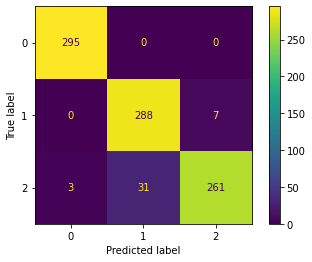

CV Runtime: 64.2687451839447 



In [66]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
scores = cross_validate(rf, data_np, target_np, scoring=scorers, cv=5)
scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))        
if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
    scores_AUC= scores['test_roc_auc']
    print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))  
else:
    y_pred = cross_val_predict(rf, data_np, target_np,  cv=5)
    print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
    ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
    plt.show()
print("CV Runtime:", time.time()-start_ts, '\n')

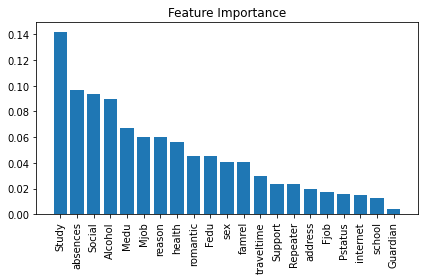

In [83]:
rf = rf.fit(data_np, target_np)
importances = rf.feature_importances_
#
# Sort the feature importance in descending order
#
feat_header = header[1:]
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(header[1:], importances[sorted_indices], align='center')
plt.xticks(range(data_np.shape[1]), [feat_header[i] for i in sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Testing on the originak data

Index(['G3', 'school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'age', 'absences'],
      dtype='object')
395 395


--OverSampling On-- 

Resample dataset shape Counter({0: 295, 1: 295, 2: 295}) 

--LOW VARIANCE FILTER ON-- 

Selected ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'age', 'absences']
Features (total, selected): 30 29


--ML Model Output-- 

Decision Tree Acc: 0.88 (+/- 0.09)
F1 score: 0.8768361581920904


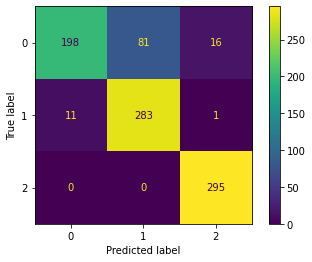

CV Runtime: 0.599963903427124 

Random Forest Acc: 0.94 (+/- 0.05)
F1 score: 0.9468926553672317


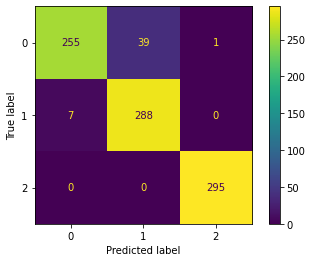

CV Runtime: 16.021403312683105 

Gradient Boosting Acc: 0.87 (+/- 0.11)
F1 score: 0.8666666666666667


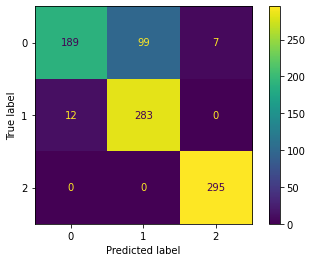

CV Runtime: 13.170864820480347 

MLP Acc: 0.83 (+/- 0.08)
F1 score: 0.8293785310734463


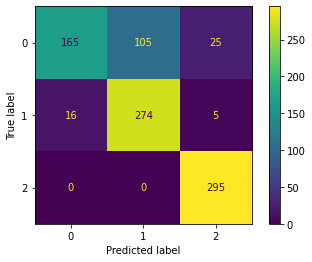

CV Runtime: 9.719353675842285 

SVM Acc: 0.87 (+/- 0.03)
F1 score: 0.8734463276836159


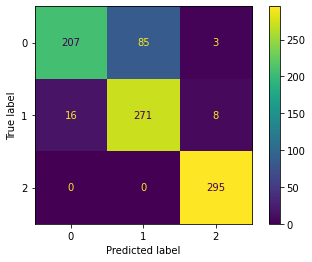

CV Runtime: 1.7170188426971436


In [3]:
#Scikit Template
'''created by Casey Bennett 2018, www.CaseyBennett.com
   Copyright 2018

   This program is free software: you can redistribute it and/or modify
   it under the terms of the GNU General Public License (Lesser GPL) as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
'''

import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import joblib
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics, svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, train_test_split, cross_val_predict
from sklearn.preprocessing import KBinsDiscretizer, scale, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
import matplotlib.pyplot as plt


#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


#############################################################################
#
# Global parameters
#
#####################

target_idx=0                                        #Index of Target variable
cross_val=1                                         #Control Switch for CV
norm_target=0                                       #Normalize target switch
norm_features=1                                     #Normalize target switch
pre_binned = 1                                      # 1 if classes are already binned, 0 otherwise
binning=1                                           #Control Switch for Bin Target
bin_cnt=3                                           #If bin target, this sets number of classes
feat_select=0                                       #Control Switch for Feature Selection
fs_type=3                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=1                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features
k_cnt=5                                             #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3
fs_custom = 0                                       #If want to pass certain feature list to build model on
imb_learning = 1                                    #Control switch for rebalancing target class
imb_type = 2                                        #Type of rebalancing to use. 1 = Undersample, 2 = Oversample, 3 = SMOTE

#Set global model parameters
rand_st=0                                           #Set Random State variable for randomizing splits on runs


#############################################################################
#
# Load Data
#
#####################

data = pd.read_csv('categorical_dataset_ML1.csv').iloc[:, 1:]
#Read Header Line
header=data.columns 

#Read data
target = data.pop('G3')

  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

data_np=np.asarray(data)
target_np=np.asarray(target)


#############################################################################
#
# Preprocess data
#
##########################################


if norm_target==1:
    #Target normalization for continuous values
    target_np=scale(target_np)

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)

if binning==1:
    if pre_binned == 0:
        #Discretize Target variable with KBinsDiscretizer
        enc = KBinsDiscretizer(n_bins=[bin_cnt], encode='ordinal', strategy='quantile')                         #Strategy here is important, quantile creating equal bins, but kmeans prob being more valid "clusters"
        target_np_bin = enc.fit_transform(target_np.reshape(-1,1))

        #Get Bin min/max
        temp=[[] for x in range(bin_cnt+1)]
        for i in range(len(target_np)):
            for j in range(bin_cnt):
                if target_np_bin[i]==j:
                    temp[j].append(target_np[i])

        for j in range(bin_cnt):
            print('Bin', j, ':', min(temp[j]), max(temp[j]), len(temp[j]))
        print('\n')

        #Convert Target array back to correct shape
        target_np=np.ravel(target_np_bin)

#Class Rebalancing
if imb_learning==1:
    
    #Undersampling
    if imb_type ==1:
        print('--UnderSampling On--', '\n')
        rus = RandomUnderSampler(random_state=rand_st, replacement=True) # fit predictor and target variable
        data_np, target_np = rus.fit_resample(data_np, target_np)

        print('Resample dataset shape', Counter(target_np), '\n')
        
    #Oversampling        
    if imb_type ==2:
        print('--OverSampling On--', '\n')
        ros = RandomOverSampler(random_state=42)
        data_np, target_np = ros.fit_resample(data_np, target_np)

        print('Resample dataset shape', Counter(target_np), '\n')
        
    #SMOTE
    if imb_type ==3:
        print('--SMOTE On--', '\n')
        smote = SMOTE()
        data_np, target_np = smote.fit_resample(data_np, target_np)

        print('Resample dataset shape', Counter(target_np), '\n')
        


#############################################################################
#
# Feature Selection
#
##########################################

#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=0.5)                                      #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = list(header[0:feat_start])
    temp = list(temp)
    header.extend(temp)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    if fs_custom == 1:
        print ('Custom Feature Selection: ')
        temp = ['Medu', 'health', 'age', 'absences', 'Alcohol', 'freetime', 'failures']
        header = list(header[0:feat_start])
        temp = list(temp)
        header.extend(temp)
        data_np = np.delete(data_np, temp_del, axis=1)
        
        
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=3, criterion='mse', random_state=None)
            sel = RFE(rgr, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=None)
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:       
        if binning==1:                                                              ######Only work if the Target is binned###########
            #Univariate Feature Selection - Chi-squared
            sel=SelectKBest(chi2, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
            print ('Univariate Feature Selection - Chi2: ')
            sel_idx=fit_mod.get_support()

        if binning==0:                                                              ######Only work if the Target is continuous###########
            #Univariate Feature Selection - Mutual Info Regression
            sel=SelectKBest(mutual_info_regression, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)                     #Doesn't always sort correctly (e.g. for Chi Sq), so doublecheck output
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = list(header[0:feat_start])
    temp = list(temp)
    header.extend(temp)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)

    
#############################################################################
#
# Train SciKit Models
#
##########################################

print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

####Classifiers####
if binning==1 and cross_val==0:    
    #SciKit Decision Tree
    clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=None)
    clf.fit(data_train, target_train)
    print('Decision Tree Acc:', clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('Decision Tree AUC:', metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))             
    #joblib.dump(clf, 'DecTree_DSC540_HW1.pkl')                     #Save and pickle model

    #SciKit Random Forest
    clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
    clf.fit(data_train, target_train)
    print('Random Forest Acc:', clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('Random Forest AUC:', metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))             
 

####Cross-Val Classifiers####
if binning==1 and cross_val==1:
    #Setup Crossval classifier scorers
    if bin_cnt<=2:
        scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
    else:
        scorers = {'Accuracy': 'accuracy'}
    
    #SciKit Decision Tree - Cross Val
    start_ts=time.time()
    dt = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=None)
    scores = cross_validate(dt, data_np, target_np, scoring=scorers,cv=5)
    scores_Acc = scores['test_Accuracy']
    print("Decision Tree Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))        
    if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
        scores_AUC= scores['test_roc_auc']
        print("Decision Tree AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))  
    else:
        y_pred = cross_val_predict(dt, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts, '\n')

    #SciKit Random Forest - Cross Val
    start_ts=time.time()
    rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
    scores = cross_validate(rf, data_np, target_np, scoring=scorers, cv=5)
    scores_Acc = scores['test_Accuracy']
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))        
    if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
        scores_AUC= scores['test_roc_auc']
        print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))  
    else:
        y_pred = cross_val_predict(rf, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts, '\n')

    
    #SciKit Gradient Boosting - Cross Val
    start_ts=time.time()
    gb= GradientBoostingClassifier(n_estimators = 100, loss = 'deviance', learning_rate = 0.1, max_depth = 3, min_samples_split = 3, random_state = rand_st)   
    scores= cross_validate(gb, X = data_np, y = target_np, scoring = scorers, cv = 5)

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Gradient Boosting Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))  
    if bin_cnt<=2: 
        scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
        print("Gradient Boosting AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2)) 
    else:
        y_pred = cross_val_predict(gb, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts, '\n')


    #SciKit Neural Network - Cross Val
    start_ts=time.time()
    mlp= MLPClassifier(activation = 'logistic', solver = 'lbfgs', alpha = 0.0001, max_iter= 1000, hidden_layer_sizes = (10, ),  random_state = rand_st)   
    scores= cross_validate(mlp, X = data_np, y = target_np, scoring = scorers, cv = 5)

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("MLP Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2)) 
    if bin_cnt<=2: 
        scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
        print("MLP AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))    
    else:
        y_pred = cross_val_predict(mlp, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts, '\n')

    #SciKit SVM - Cross Val
    #data must be scaled
    data_np = StandardScaler().fit_transform(data_np)
    start_ts=time.time()
    svm_mod= svm.SVC(random_state = rand_st, C = 1)
        
    scores= cross_validate(svm_mod, X = data_np, y = target_np, scoring = scorers, cv = 5)
    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("SVM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2)) 
    if bin_cnt<=2: 
        scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
        print("MLP AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))    
    else:
        y_pred = cross_val_predict(svm_mod, data_np, target_np,  cv=5)
        print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
        ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
        plt.show()
    print("CV Runtime:", time.time()-start_ts)

Random Forest Acc: 0.94 (+/- 0.04)
F1 score: 0.9457627118644067


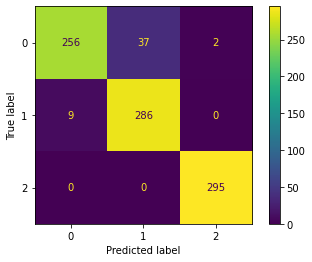

CV Runtime: 56.87471413612366 



In [4]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
scores = cross_validate(rf, data_np, target_np, scoring=scorers, cv=5)
scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))        
if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
    scores_AUC= scores['test_roc_auc']
    print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))  
else:
    y_pred = cross_val_predict(rf, data_np, target_np,  cv=5)
    print('F1 score:',f1_score(target_np, y_pred, average = 'micro'))
    ConfusionMatrixDisplay.from_predictions(target_np, y_pred)
    plt.show()
print("CV Runtime:", time.time()-start_ts, '\n')

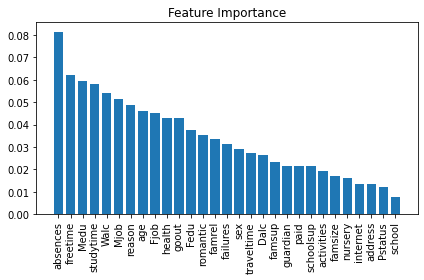

In [5]:
rf = rf.fit(data_np, target_np)
importances = rf.feature_importances_
#
# Sort the feature importance in descending order
#
feat_header = header[1:]
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(header[1:], importances[sorted_indices], align='center')
plt.xticks(range(data_np.shape[1]), [feat_header[i] for i in sorted_indices], rotation=90)
plt.tight_layout()
plt.show()